In [1]:
import sys
sys.path.insert(0,'../paper_stuff/')

import torch
from pt_model import LSTM, SampleDataset
import pickle
import pandas as pd
import numpy as np

In [2]:
torso_r = list(range(1, 2))
head_r = list(range(26, 27))
r_hand_r = list(range(14, 18))
l_hand_r = list(range(7, 11))

features = ([f'j_{j}_sin' for j in head_r] + [f'j_{j}_cos' for j in head_r]+
                         [f'j_{j}_sin' for j in torso_r] + [f'j_{j}_cos' for j in torso_r]+
                         [f'j_{j}_{c}' for j in torso_r for c in 'xy'])

In [3]:
with open(f'ds_viktor.pkl', 'rb') as f:
        df = pickle.load(f)
sequence_ids = [df[df['sample_id']==sample_id].index for sample_id in df['sample_id'].unique()]


In [4]:
len(sequence_ids)

58

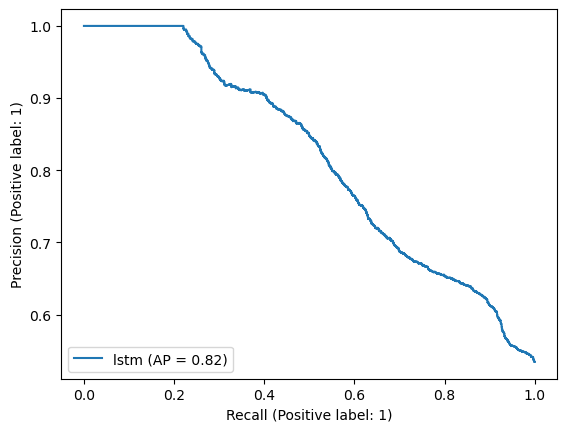

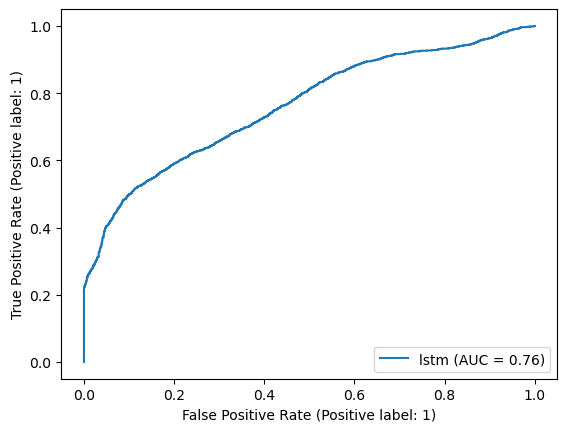

In [5]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

table = {"auroc":[], "apr":[], "acc":[]}
d_table = {"d_bin":[], "auroc":[], "apr":[]}


feature_list = features
y_pred = []
d_bins = [0.75, 1.0, 1.25, 2., 2.5, 3., 3.5]#, 4., 20.]
y_d_pred = {d: [] for d in d_bins}
y_d_true = {d: [] for d in d_bins}
y_true = []

testset = SampleDataset(df,
                    feature_list + ['xy_dist'],
                    sequence_ids)
test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False, drop_last=False)

with open("../models/lstm.info") as f:
    info = eval(f.read())
device = torch.device('cpu')
model = LSTM(input_size=info['input_size'], hidden_size=info['hidden_size'], out_size=1,
             num_layers=info['num_layers']).to(device)
        
model.load_state_dict(torch.load("../models/lstm.pth", map_location=torch.device('cpu')))
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.squeeze(0).to(device), target.squeeze(0).to(device)
        output = torch.sigmoid(model(data[:, :-1], model.init_hidden())[0].squeeze())
        y_true.append(target.cpu().numpy())
        y_pred.append(output.cpu().numpy())

        for d_i, d in enumerate(d_bins):
            if d_i == 0:
                mask = data[:, -1] <= d
#                     elif d_i == len(d_bins):
#                         mask = data[:, -1] > d
            else:
                mask = (data[:, -1] > d_bins[d_i-1]) & (data[:, -1] <= d)
            mask = mask.cpu().numpy()
            if np.sum(mask)>0:
                y_d_pred[d].append(output.cpu().numpy()[mask])
                y_d_true[d].append(target.cpu().numpy()[mask])

y_true = np.hstack(y_true)
for d in y_d_true:
    y_d_true[d] = np.hstack(y_d_true[d])


y_pred = np.hstack(y_pred)
PrecisionRecallDisplay.from_predictions(y_true, y_pred, name=f"lstm")
RocCurveDisplay.from_predictions(y_true, y_pred, name=f"lstm")
table['auroc'].append(roc_auc_score(y_true, y_pred))
table['apr'].append(average_precision_score(y_true, y_pred))
table['acc'].append(np.mean((y_pred>0.5)==y_true))

for d in y_d_pred:
    y_d_pred[d] = np.hstack(y_d_pred[d])
    d_table['d_bin'].append(d)
    if np.all(y_d_true[d]==1) or np.all(y_d_true[d]==0):
        d_table['auroc'].append(np.nan)
        d_table['apr'].append(np.nan)
    else:
        d_table['auroc'].append(roc_auc_score(y_d_true[d], y_d_pred[d]))
        d_table['apr'].append(average_precision_score(y_d_true[d], y_d_pred[d]))
#             d_table['acc'].append(np.mean((y_pred[name]>0.5)==y_true))

In [6]:
d_table

{'d_bin': [0.75, 1.0, 1.25, 2.0, 2.5, 3.0, 3.5],
 'auroc': [nan,
  nan,
  nan,
  nan,
  0.8017265385686438,
  0.8347377630427776,
  0.7968953843613246],
 'apr': [nan,
  nan,
  nan,
  nan,
  0.9355376987427686,
  0.7106198393855226,
  0.6001026876532451]}

In [7]:
table

{'auroc': [0.7615271315018713],
 'apr': [0.8163701591116188],
 'acc': [0.6661994393271926]}

In [8]:
df['prediction'] = y_pred

In [9]:
def compute_metrics(seq):
    metrics = {
               'th':[], 
               'detection':[], 
               'label':[], 
               'ts_detection':[], 
               'time_to_detect':[],
               'anticipation':[],
               'ts_interact':[],
               'distance': []
              }
    label = np.any(seq['new_label'])
    if label:
        ts_interact = seq['timestamp'].iloc[-1]#seq.loc[seq['start_label'], 'timestamp'].iloc[0]
    else:
        ts_interact = pd.NaT
    
    for th in np.linspace(0, 1, num=99):
        #for model in [f'{m_name}_{i}_pred' for m_name in m_names for i in features_d]:
        pred_avg = seq['prediction'].rolling(7).mean()
        pred = pred_avg >=th

        #detection = np.sum(pred) > 10
        detection = np.any(pred)

        ts_detection = pd.NaT
        time_to_detect = np.nan
        delay = np.nan    
        distance = np.nan
        if detection:
            detect_idx = pred.idxmax() # get first true idx
#             detect_idx = seq.index[pred][9]
            ts_detection = seq.loc[detect_idx, 'timestamp']
            distance = seq.loc[detect_idx, 'xy_dist']
            time_to_detect = (ts_detection - seq['timestamp'].min()).total_seconds()
            if label:
                delay = (ts_detection-ts_interact).total_seconds()

        metrics[f'th'].append(th)
        metrics[f'detection'].append(detection)
        metrics[f'label'].append(label)
        metrics[f'ts_detection'].append(ts_detection)
        metrics[f'time_to_detect'].append(time_to_detect)
        metrics[f'anticipation'].append(delay)
        metrics[f'ts_interact'].append(ts_interact)
        metrics[f'distance'].append(distance)


    return pd.DataFrame(metrics)

In [10]:
metrics = df.groupby(['sample_id']).apply(compute_metrics)

In [11]:
metrics

th  detection  label               ts_detection  \
sample_id                                                             
0         0   0.000000       True  False 2023-07-20 11:03:29.440748   
          1   0.010204       True  False 2023-07-20 11:03:29.440748   
          2   0.020408       True  False 2023-07-20 11:03:29.440748   
          3   0.030612       True  False 2023-07-20 11:03:29.440748   
          4   0.040816       True  False 2023-07-20 11:03:29.440748   
...                ...        ...    ...                        ...   
57        94  0.959184       True   True 2023-07-20 15:25:10.941130   
          95  0.969388       True   True 2023-07-20 15:25:10.941130   
          96  0.979592       True   True 2023-07-20 15:25:11.074549   
          97  0.989796       True   True 2023-07-20 15:25:11.207697   
          98  1.000000      False   True                        NaT   

              time_to_detect  anticipation                ts_interact  \
sample_id                                                               
0         0         0.533751           NaN                        NaT   
          1         0.533751           NaN                        NaT   
          2         0.533751           NaN                        NaT   
          3         0.533751           NaN                        NaT   
          4         0.533751           NaN                        NaT   
...                      ...           ...                        ...   
57        94        2.868471     -1.332514 2023-07-20 15:25:12.273644   
          95        2.868471     -1.332514 2023-07-20 15:25:12.273644   
          96        3.001890     -1.199095 2023-07-20 15:25:12.273644   
          97        3.135038     -1.065947 2023-07-20 15:25:12.273644   
          98             NaN           NaN 2023-07-20 15:25:12.273644   

              distance  
sample_id               
0         0   7.068327  
          1   7.068327  
          2   7.068327  
          3   7.068327  
          4   7.068327  
...                ...  
57        94  2.453367  
          95  2.453367  
          96  2.228046  
          97  2.044385  
          98       NaN  

[5742 rows x 8 columns]

In [12]:
with open('metrics_victor.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [31]:
from datetime import timedelta
def f(ttdf):    
    ret = {'recall': [], 
           'precision': [], 
           'fpr': [], 
           'anticipation': [],
           'accuracy': [],
           'f1': []
          }
    dts = []
    tp_m = ttdf["detection"] & ttdf["label"]
    tp = (tp_m).sum()
    fp_m = ttdf["detection"] & ~ttdf["label"]
    fp = (fp_m).sum()
    tn_m = ~ttdf["detection"] & ~ttdf["label"]
    tn = (tn_m).sum()
    fn_m = ~ttdf["detection"] & ttdf["label"]
    fn = (fn_m).sum()
    
    recall = tp/(tp+fn)
    ret['recall'].append(recall)
    precision = tp/(tp+fp) if (tp+fp) else np.nan
    ret['precision'].append(precision) # to avoid print divide by 0 error
    
    ret['fpr'].append(fp/(fp+tn))
    
    #Accuracy = (TP+TN)/(TP+FP+FN+TN)
    ret['accuracy'].append((tp+tn)/(tp+tn+fp+fn))
    ret['anticipation'].append(ttdf[tp_m]['anticipation'].abs().mean())
    ret['f1'].append(2*(precision*recall)/(precision+recall))
    dts.append(0)
    for dt in [1, 2, 3, 4]:
        start_ts = (ttdf['ts_interact']-timedelta(seconds=dt)) # note NaT-val=NaT
        tp = (tp_m & (ttdf['ts_detection']<=start_ts)).sum() # note NaT compared to something, even NaT is False
        fp = fp_m.sum()
        tn = tn_m.sum()
        fn = (fn_m | (tp_m & (ttdf['ts_detection']>start_ts))).sum()
        
        assert len(ttdf)-tp-fp-tn == fn
        
        recall = tp/(tp+fn)
        ret['recall'].append(recall)
        precision = tp/(tp+fp) if (tp+fp) else np.nan
        ret['precision'].append(precision) # to avoid print divide by 0 error     
        ret['fpr'].append(fp/(fp+tn))
        ret['accuracy'].append((tp+tn)/(tp+tn+fp+fn))
        ret['f1'].append(2*(precision*recall)/(precision+recall))
        delay_mask = tp_m & (ttdf['ts_detection']<=start_ts)
        delay = (ttdf[delay_mask]['ts_detection']-ttdf[delay_mask]['ts_interact']).abs().mean().total_seconds()
        ret['anticipation'].append(delay)
        dts.append(dt)
    
    ret = pd.DataFrame(ret, index=dts)
    ret.index.name = "dt"
    return ret

tab = metrics.groupby(["th"]).apply(f)


In [32]:
import matplotlib.pyplot as plt

def plot_metrics(tab, axes):
#         print(len(tab.recall))
#         display(tab)
#         ax.plot('recall', 'precision', data=g, label=f"PR-Curve dt={n}s")
#         ax.plot(range(len(g.precision)), g.precision)
#         ax.plot(range(len(g.recall)), g.recall)
#         ax.plot(range(len(tab.anticipation)), tab.anticipation)
#         ax.plot(tab.th, tab.anticipation)
        axes[0].plot(tab.th, tab.precision.fillna(1), label='precision')
        axes[0].plot(tab.th, tab.recall, label='recall')
        axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[0].legend()
        axes[1].plot('fpr', 'recall', data=tab, label=f"ROC-Curve")
        axes[1].set(xlabel="FPR", ylabel="TPR", xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].legend()
        axes[2].plot(tab.th, tab.anticipation, label="Mean Anticipation")
        axes[2].set(xlabel="Threshold", ylabel="Anticipation [s]")#, xlim=[0, 1])
        
        axes[3].plot(tab.th, tab.accuracy, label='accuracy')
        axes[3].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[3].legend()
        
        
#         ax[0].plot(tab.th, tab.recall)
#         ax.plot(g.precision, g.recall, g.index.get_level_values(0))
#         axes[1, 1].plot('fpr', 'recall', data=g, label=f"ROC-Curve dt={n}s")
#         axes[1, 1].set(xlabel="FPR", ylabel="TPR", xlim=[0, 1], ylim=[0, 1])
#         axes[1, 1].legend()


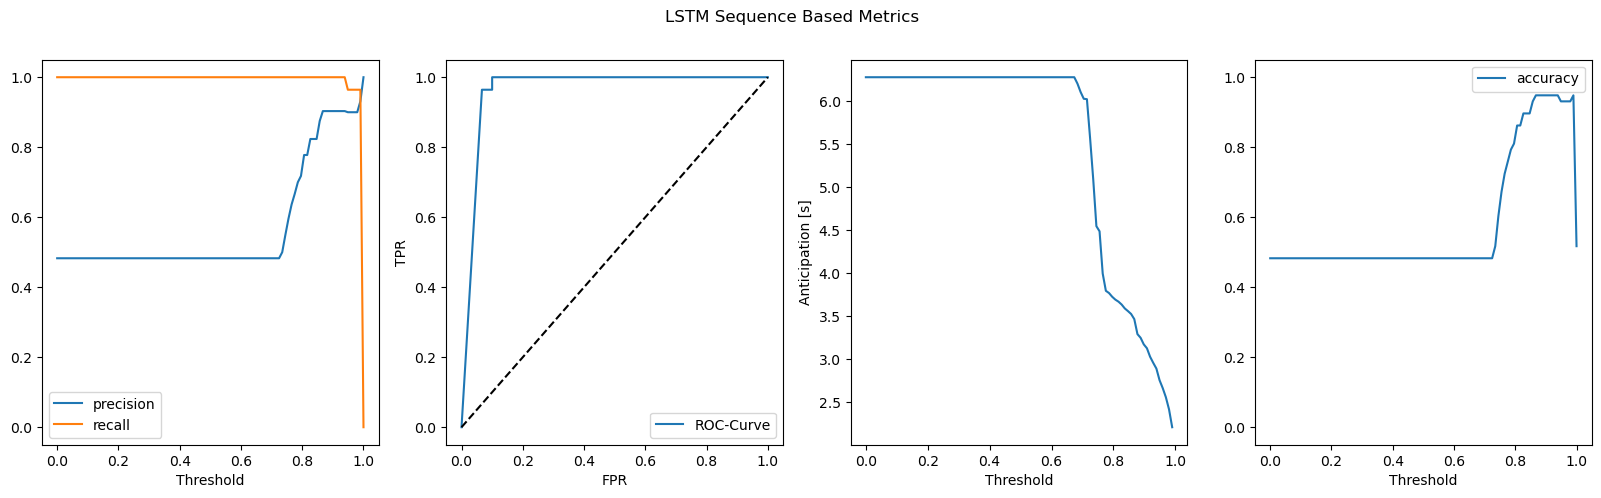

In [33]:
dt=0
to_plot = tab.reset_index(0)
fig,axes= plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"LSTM Sequence Based Metrics")
plot_metrics(to_plot.xs(dt), axes)

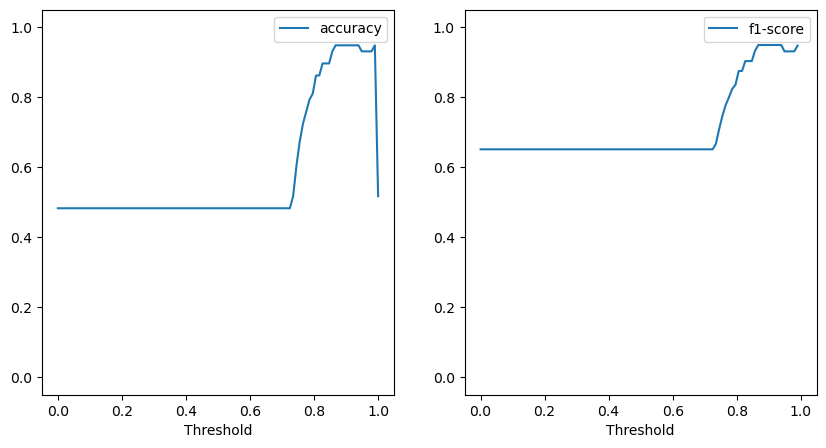

In [37]:
dt=0
to_plot = tab.reset_index(0)
fig,axes= plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(to_plot.xs(dt).th, to_plot.xs(dt).accuracy, label='accuracy')
axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axes[0].legend()

axes[1].plot(to_plot.xs(dt).th, to_plot.xs(dt).f1, label='f1-score')
axes[1].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axes[1].legend()
plt.show()

In [38]:
# AUROC
np.trapz(to_plot.xs((dt)).recall, to_plot.xs((dt)).th)

0.993075801749271

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(tab, axd):
    last_p = tab.precision.isna().values.argmax()+10
    
    axd['left'].plot('fpr', 'recall', data=tab, label=f"ROC-Curve")
    axd['left'].set_xlabel("False positive rate", fontsize=label_size)
    axd['left'].set_ylabel("True positive rate", fontsize=label_size)
    axd['left'].set(xlim=[0, 1.], ylim=[0, 1.025])
    axd['left'].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axd['left'].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axd['left'].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, ""])
    
#     axd['left'].set_box_aspect(1)
    display(tab)
    xlim_right = [0.65, 1.]
    tab = tab[tab.th>=0.5]
    axd['upper right'].plot(tab.th, tab.precision.fillna(1), label='precision')
    axd['upper right'].plot(tab.th, tab.recall, label='recall')
    axd['upper right'].yaxis.tick_right()
    axd['upper right'].set_ylabel("Precision, Recall", fontsize=label_size)
    axd['upper right'].yaxis.set_label_position("right")
    axd['upper right'].set(xlim=xlim_right)
    
#     axd['upper right'].set_ylabel("True Positive Rate", fontsize=6)
#     axd['upper right'].set(xlabel='Threshold', )#xlim=[-0.05, 0.77], ylim=[0.1, 1.05])
#     axd['upper right'].set_box_aspect(1)
#     axd['upper right'].legend()
    axd['upper right'].set_xticklabels([])
    # for minor ticks
#     axd['upper right'].set_xticks([], minor=True)
#     axd['left'].legend()
    axd['lower right'].plot(tab.th, tab.anticipation, label="Mean Anticipation")
    axd['lower right'].set(ylim=[0, 7.], xlim=xlim_right)
    axd['lower right'].set_ylabel("Advance detection [s]", fontsize=label_size)
    axd['lower right'].set_xlabel("Threshold", fontsize=label_size)
    axd['lower right'].set_yticks([0, 3, 6])
#     axd['lower right'].set_xticks([0.7, 0.75, 0.8, 0.85, 0.9])
    axd['lower right'].yaxis.tick_right()
    axd['lower right'].yaxis.set_label_position("right")
#     axd['lower right'].set_box_aspect(1)

,th,recall,precision,fpr,anticipation
dt,,,,,
0,0.000000,1.000000,0.482759,1.000000,6.274096
0,0.010204,1.000000,0.482759,1.000000,6.274096
0,0.020408,1.000000,0.482759,1.000000,6.274096
0,0.030612,1.000000,0.482759,1.000000,6.274096
0,0.040816,1.000000,0.482759,1.000000,6.274096
...,...,...,...,...,...
0,0.959184,0.964286,0.900000,0.100000,2.665268
0,0.969388,0.964286,0.900000,0.100000,2.559036
0,0.979592,0.964286,0.900000,0.100000,2.418269


<Figure size 350x350 with 0 Axes>

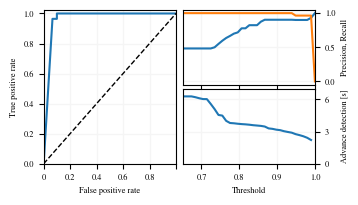

In [16]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
#import colorcet as cc
#import skimage

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
label_size = 6 # anche 7 se serve
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(3.5, 3.5),)
fig = plt.figure(figsize=(3.5, 2.),)

axd = fig.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']])
# axd['upper right'].get_shared_x_axes().join(axd['upper right'], axd['lower right'])

# dt=0
# to_plot = tab.reset_index(-2).sort_index()

dt=0
to_plot = tab.reset_index(0)
# fig,axes= plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle(f"LSTM Sequence Based Metrics")
# plot_metrics(to_plot.xs(dt), axes)
# fig,axes= plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle(f"Model {model}, Features Set {feat}")
plot_metrics(to_plot.xs((dt)), axd)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for ax in axd.values():
    plt.sca(ax)
    plt.grid(linestyle='-',linewidth=1,color='whitesmoke')
fig.align_ylabels()
# fig.tight_layout()
# plt.savefig("images/sequence_based.pdf",  bbox_inches='tight')
plt.savefig("sequence_based.svg",  bbox_inches='tight')

0.993075801749271